In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from fbprophet import Prophet

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#this allows us to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)

#filter future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#set our code up so that it doesn't display scientific notation, we want full numbers
pd.set_option('display.float_format', '{:.2f}'.format)

ModuleNotFoundError: No module named 'fbprophet'

In [23]:
#import all of our data and merge the separate files into one training set
items = pd.read_csv('items.csv')
#have to unzip zipped.gz file here rather than convert to csv in excel becuase it is too large to import from excel 
sales = pd.read_csv('sales_train.csv.gz', compression = 'gzip')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')

#merge data
data1 = pd.merge(sales, shops)
data2 = pd.merge(items, categories)
train = pd.merge(data1, data2)

#get test data in
test = pd.read_csv('test.csv')

#look at the head/tail of our data
train.head()
train.tail()
train.shape

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2935844,03.10.2015,33,20,21047,1899.00,1.00,"Москва ""Распродажа""",Футболка Borderlands Jack Hero XL,61,Подарки - Атрибутика
2935845,01.10.2015,33,20,21012,1899.00,1.00,"Москва ""Распродажа""",Футболка Assassin's Creed Syndicate Rook S,61,Подарки - Атрибутика
2935846,03.10.2015,33,20,20451,1699.00,1.00,"Москва ""Распродажа""","Фигурка DC Classic 8"" Wonder Women Head Knocker",72,Подарки - Фигурки
2935847,04.10.2015,33,20,20453,5399.00,1.00,"Москва ""Распродажа""",Фигурка DC Universe Online Solomon Grundy Stat...,72,Подарки - Фигурки
2935848,01.10.2015,33,20,19965,4399.00,1.00,"Москва ""Распродажа""",Толстовка Batman Arkham Knight с ушками L,61,Подарки - Атрибутика


(2935849, 10)

In [271]:
test.nunique()
train.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19993
item_cnt_day            198
shop_name                60
item_name             21807
item_category_id         84
item_category_name       84
dtype: int64

In [272]:
#how many of these items are in the test set as well?
test['item_id'].isin(train['item_id']).value_counts()

True     198954
False     15246
Name: item_id, dtype: int64

__How many item_ids are in the test set that are not in the train set?__

In [116]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))

363

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 425475 to 2115493
Data columns (total 14 columns):
date                  datetime64[ns]
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
shop_name             object
item_name             object
item_category_id      int64
item_category_name    object
sale_month            int64
sale_day              int64
sale_year             int64
holiday?              bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(7), object(3)
memory usage: 316.4+ MB


In [146]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [64]:
train.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
item_category_name     object
sale_month              int64
sale_day                int64
sale_year               int64
dtype: object

__Order our data by date, make it intuitively sequential__

In [3]:
#convert date to datetime
import datetime
#formatting the date column correctly
train.date=train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
date                  datetime64[ns]
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
shop_name             object
item_name             object
item_category_id      int64
item_category_name    object
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB
None


In [4]:
train.sort_values(by = ['date'], inplace=True)

In [5]:
train.tail()
train.shape

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2307682,2015-10-31,33,31,18106,3799.00,1.00,"Москва ТЦ ""Семеновский""",Рюкзак Minecraft Creeper,61,Подарки - Атрибутика
2026903,2015-10-31,33,52,15213,999.00,1.00,"Уфа ТК ""Центральный""",Мягкая игрушка Adventure Time BMO 18см,63,Подарки - Мягкие игрушки
2410817,2015-10-31,33,25,11931,299.00,1.00,"Москва ТРК ""Атриум""",ИГРОК (BD),37,Кино - Blu-Ray
810637,2015-10-31,33,24,4420,299.00,1.00,"Москва ТК ""Буденовский"" (пав.К7)",LINKIN PARK Hybrid Theory,55,Музыка - CD локального производства
2115493,2015-10-31,33,39,20736,499.00,1.00,"РостовНаДону ТРК ""Мегацентр Горизонт""","Фигурка Scalers Wave 2 Batman 2""",72,Подарки - Фигурки


(2935849, 10)

__Looking at date block number sales__

<Figure size 1440x720 with 0 Axes>

date_block_num
0    131479.00
1    128090.00
2    147142.00
3    107190.00
4    106970.00
5    125381.00
6    116966.00
7    125291.00
8    133332.00
9    127541.00
10   130009.00
11   183342.00
12   116899.00
13   109687.00
14   115297.00
15    96556.00
16    97790.00
17    97429.00
18    91280.00
19   102721.00
20    99208.00
21   107422.00
22   117845.00
23   168755.00
24   110971.00
25    84198.00
26    82014.00
27    77827.00
28    72295.00
29    64114.00
30    63187.00
31    66079.00
32    72843.00
33    71056.00
Name: item_cnt_day, dtype: float64

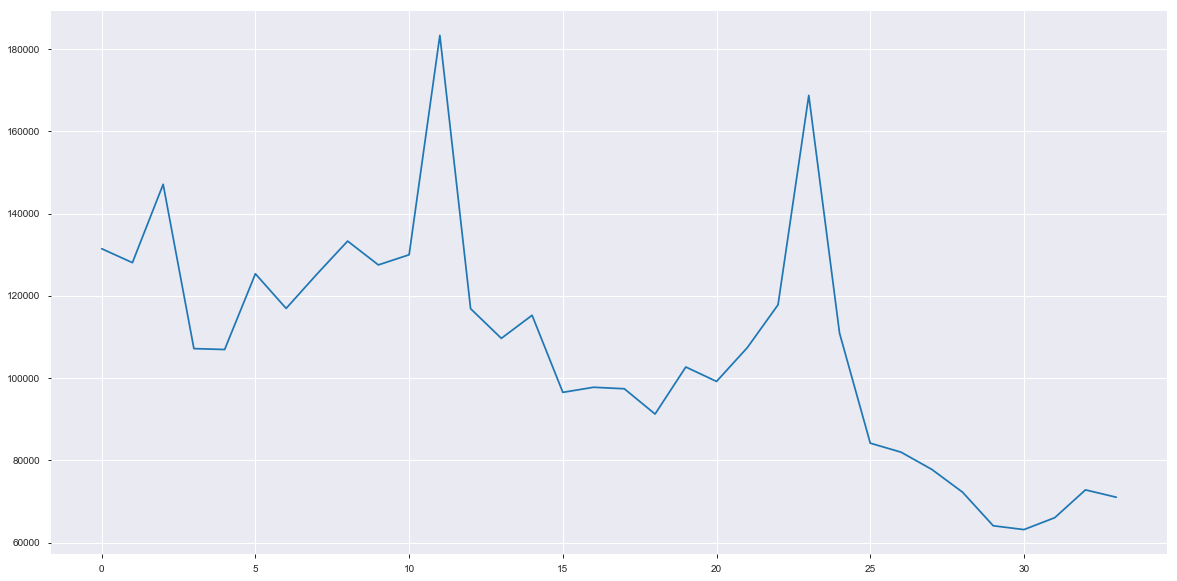

In [72]:
time_sales = train.groupby('date_block_num').item_cnt_day.sum()
plt.figure(figsize=(20, 10))
time_sales.astype('float')
plt.plot(time_sales)

In [10]:
october_data = train[train['date'].dt.month == 10]
october_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1621409,2013-10-01,9,3,786,359.00,1.00,"Балашиха ТРК ""Октябрь-Киномир""",1С:Предпр.8. Управление торг.операциями в вопр...,49,Книги - Методические материалы 1С
1221353,2013-10-01,9,44,3183,599.00,1.00,"Самара ТЦ ""Мелодия""","Elder Scrolls V: Skyrim Legendary Edition [PC,...",30,Игры PC - Стандартные издания
1245625,2013-10-01,9,18,2406,84.88,1.00,"Красноярск ТЦ ""Июнь""","Confrontation. Последняя битва [PC, Jewel, рус...",30,Игры PC - Стандартные издания
1643780,2013-10-01,9,26,15887,2159.00,1.00,"Москва ТЦ ""Ареал"" (Беляево)","Набор из двух танков ""Танковый бой"" Blue Sea ...",62,"Подарки - Гаджеты, роботы, спорт"
2902357,2013-10-01,9,55,4750,30.00,1.00,Цифровой склад 1С-Онлайн,Majesty 2. The Fantasy Kingdom. Наговор хрупко...,31,Игры PC - Цифра


__I am going to submit these predictions based on October sales data from 2013, 2014, and 2015, I still need to figure out lagging these values__
- this resulted in a preliminary score of 2.13 (ugh)

In [18]:
pred = october_data[['item_cnt_day']].clip(0, 20)
pred.shape
#pred.to_csv('time_pred.csv')

(227077, 1)

# Previous Value Benchmark
- getting lagged values and predicting 
- I am doing this based on the coursera advice 

In [33]:
#melting the data
train.head().T

,425475,320684,2516919,1014641,1014721
date,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
date_block_num,0,0,0,0,0
shop_id,54,37,46,7,15
item_id,11857,3210,16870,5275,5275
item_price,729.00,149.00,379.00,1698.70,1699.00
item_cnt_day,1.00,1.00,1.00,1.00,1.00
shop_name,"Химки ТЦ ""Мега""","Новосибирск ТЦ ""Мега""","Сергиев Посад ТЦ ""7Я""","Воронеж ТРЦ ""Максимир""","Калуга ТРЦ ""XXI век"""
item_name,Змей ВАСЯ антистресс 36 см.,Eplay. Самые увлекательные игры. Магазинчик уж...,ПАРАЛЛЕЛЬНЫЕ МИРЫ,Need for Speed: Most Wanted (a Criterion Game)...,Need for Speed: Most Wanted (a Criterion Game)...
item_category_id,63,30,40,22,22
item_category_name,Подарки - Мягкие игрушки,Игры PC - Стандартные издания,Кино - DVD,Игры - PSVita,Игры - PSVita


In [35]:
october_2015_data = train[train['date_block_num'] == 33]
october_2015_data.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2307682,2015-10-31,33,31,18106,3799.00,1.00,"Москва ТЦ ""Семеновский""",Рюкзак Minecraft Creeper,61,Подарки - Атрибутика
2026903,2015-10-31,33,52,15213,999.00,1.00,"Уфа ТК ""Центральный""",Мягкая игрушка Adventure Time BMO 18см,63,Подарки - Мягкие игрушки
2410817,2015-10-31,33,25,11931,299.00,1.00,"Москва ТРК ""Атриум""",ИГРОК (BD),37,Кино - Blu-Ray
810637,2015-10-31,33,24,4420,299.00,1.00,"Москва ТК ""Буденовский"" (пав.К7)",LINKIN PARK Hybrid Theory,55,Музыка - CD локального производства
2115493,2015-10-31,33,39,20736,499.00,1.00,"РостовНаДону ТРК ""Мегацентр Горизонт""","Фигурка Scalers Wave 2 Batman 2""",72,Подарки - Фигурки


__Here we are creating a dataframe with the total "item count for the month" for each shop/item combination__

In [37]:
df_m = october_2015_data.groupby(["shop_id", "item_id"])
month_sum = df_m.aggregate({"item_cnt_day":np.sum}).fillna(0)
month_sum.reset_index(level=["shop_id", "item_id"], inplace=True)
month_sum = month_sum.rename(columns={ month_sum.columns[2]: "item_cnt_month" })
month_sum.describe()

,shop_id,item_id,item_cnt_month
count,31531.00,31531.00,31531.00
mean,31.63,10896.73,2.25
std,16.49,6165.33,14.53
min,2.00,30.00,-1.00
25%,19.00,5240.00,1.00
50%,31.00,11056.00,1.00
75%,46.00,15805.00,2.00
max,59.00,22167.00,2253.00


In [49]:
october_2015_data.groupby(['shop_id', 'item_id']).item_cnt_day.sum()

shop_id  item_id
2        31         1.00
         486        3.00
         787        1.00
         794        1.00
         968        1.00
         988        1.00
         1075       1.00
         1121       1.00
         1377       1.00
         1387       1.00
         1389       1.00
         1466       2.00
         1486       1.00
         1523       1.00
         1534       1.00
         1535       1.00
         1540       2.00
         1556       1.00
         1560       1.00
         1563       1.00
         1569       1.00
         1571       1.00
         1578       4.00
         1579       1.00
         1583       9.00
         1586       1.00
         1813       1.00
         1847       2.00
         1857       1.00
         1876       1.00
                    ... 
59       19894      1.00
         19985      1.00
         20303      1.00
         20305      1.00
         20335      1.00
         20355      1.00
         20392      1.00
         20604      2.00
        

In [46]:
test.describe()

,ID,shop_id,item_id
count,214200.00,214200.00,214200.00
mean,107099.50,31.64,11019.40
std,61834.36,17.56,6252.64
min,0.00,2.00,30.00
25%,53549.75,16.00,5381.50
50%,107099.50,34.50,11203.00
75%,160649.25,47.00,16071.50
max,214199.00,59.00,22167.00


Something doesn't seem right - the number of rows is far less than the submission dataframe.

I see what's going on. If the total item_cnt_month is 0 then item_id for the corresponding shop_id is not included.

This could be fixed by simply merging month_sum with the test dataframe and filling the NaNs.

We will map the shop_id-item_id to ID number in the test set for our next step, and finally make a submission dataframe.

In [41]:
new_submission = pd.merge(month_sum, test, how='right', left_on=['shop_id','item_id'], right_on = ['shop_id','item_id']).fillna(0)
new_submission.drop(['shop_id', 'item_id'], axis=1)
new_submission = new_submission[['ID','item_cnt_month']]

,item_cnt_month,ID
0,1.00,20994
1,3.00,21001
2,1.00,20986
3,1.00,22120
4,1.00,22459
5,1.00,21736
6,1.00,23486
7,1.00,20972
8,1.00,21682
9,1.00,21683


The current score is quite horrible, at 8.53027. Let's try to clip the values within [0,20] as per the tip from the course.

In [42]:
new_submission['item_cnt_month'] = new_submission['item_cnt_month'].clip(0,20)
new_submission.describe()

,ID,item_cnt_month
count,214200.00,214200.00
mean,107099.50,0.26
std,61834.36,1.09
min,0.00,0.00
25%,53549.75,0.00
50%,107099.50,0.00
75%,160649.25,0.00
max,214199.00,20.00


In [43]:
new_submission.to_csv('previous_value_benchmark.csv', index=False)

The score now is 1.16777 as expected! Awesome. Now we can start trying some models in another kernel.

# Get the Russian holidays and create boolean holiday feature

In [75]:
from datetime import date
import holidays
rus_holidays = holidays.RU()

In [76]:
for ptr in holidays.Russia(years = 2013).items(): 
    print(ptr)

(datetime.date(2013, 1, 1), 'Новый год')
(datetime.date(2013, 1, 2), 'Новый год')
(datetime.date(2013, 1, 3), 'Новый год')
(datetime.date(2013, 1, 4), 'Новый год')
(datetime.date(2013, 1, 5), 'Новый год')
(datetime.date(2013, 1, 6), 'Новый год')
(datetime.date(2013, 1, 7), 'Православное Рождество')
(datetime.date(2013, 1, 8), 'Новый год')
(datetime.date(2013, 2, 23), 'День защитника отечества')
(datetime.date(2013, 3, 8), 'День женщин')
(datetime.date(2013, 5, 1), 'Праздник Весны и Труда')
(datetime.date(2013, 5, 9), 'День Победы')
(datetime.date(2013, 6, 12), 'День России')
(datetime.date(2013, 11, 4), 'День народного единства')


__This cell needs to be run before pandas will show holidays in the date column__
- I do not know why this is the case, but creating this feature was one of the most touchy and frustrating processes 

In [77]:
date (2013, 1, 5) in rus_holidays

True

__Now create our 'holiday?' column__

In [78]:
train['holiday?'] = train['date'].isin(rus_holidays)

In [79]:
#what are our value counts?
train['holiday?'].value_counts()

False    2867838
True       68011
Name: holiday?, dtype: int64

In [80]:
#see if these values match up correctly
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,sale_month,sale_day,sale_year,holiday?
425475,2013-01-01,0,54,11857,729.00,1.00,"Химки ТЦ ""Мега""",Змей ВАСЯ антистресс 36 см.,63,Подарки - Мягкие игрушки,1,1,2013,True
320684,2013-01-01,0,37,3210,149.00,1.00,"Новосибирск ТЦ ""Мега""",Eplay. Самые увлекательные игры. Магазинчик уж...,30,Игры PC - Стандартные издания,1,1,2013,True
2516919,2013-01-01,0,46,16870,379.00,1.00,"Сергиев Посад ТЦ ""7Я""",ПАРАЛЛЕЛЬНЫЕ МИРЫ,40,Кино - DVD,1,1,2013,True
1014641,2013-01-01,0,7,5275,1698.70,1.00,"Воронеж ТРЦ ""Максимир""",Need for Speed: Most Wanted (a Criterion Game)...,22,Игры - PSVita,1,1,2013,True
1014721,2013-01-01,0,15,5275,1699.00,1.00,"Калуга ТРЦ ""XXI век""",Need for Speed: Most Wanted (a Criterion Game)...,22,Игры - PSVita,1,1,2013,True


# Create a translate function 

In [263]:
def translate(x):
    from translate import Translator
    translator= Translator(from_lang="russian",to_lang="english")
    translation = translator.translate(x)
    print (translation)

__some of these holidays do not translate into English, I wonder if that is becuase the translator is not familiar with these characters?__
- nevertheless, we get an idea of what these holidays are

In [152]:
translate('Новый год')
translate('Православное Рождество')
translate('День женщин')
translate('Праздник Весны и Труда')
translate('День Победы')
translate('День России')
translate('День народного единства')
translate('День защитника отечества')

New Year
Orthodox Christmas Day
Women’s Day
Spring and Labor Day
Day of Victory
Russia Day
National Unity Day
-Ð¸Ð³Ñ Ñ Ñ ÐµÐº


__Translate our item category names so we can see what they are__
- I used two different translators here, apparently you can only translate things a certain number of times per day, and I reached my limit

In [18]:
#THIS IS ANOTHER TRANSLATOR THAT I CAN USE ONCE I HAVE USED UP ALL MY DAILY TRANSLATIONS
# import goslate
# gs = goslate.Goslate()
# print(gs.translate('День народного единства', 'en'))

In [19]:
#create a dataframe from the item_category_name column so that we can apply a row-wise translator
df = pd.DataFrame(train['item_category_name'].unique())
df.head()

,0
0,Подарки - Настольные игры (компактные)
1,Кино - DVD
2,Кино - Blu-Ray 3D
3,Игры - PSVita
4,Игры PC - Стандартные издания


In [153]:
df = pd.DataFrame(train['item_category_name'].unique())
for row in df.iloc[:,0]:
    translate(row)

Gifts - Board Games (Compact)
Cinema - DVD
Cinema - Blu-ray 3D
Games - PSVita
PC Games - Standard Editions
Accessories - XBOX 360
PC Games - Additional Editions
Music - Local Production CD
Gifts - Figures
Accessories - PSVita
Gifts - Development
Games - PS3
Programs - Home and Office
Gifts - Gadgets, Robots, Sports
Games - Accessories for games
Accessories - PSP
Cinema - Collection
Gaming Consoles - XBOX 360
Music - MP3
Music - Music Video
Music - Gift Edition
Gifts - Soft Toys
Souvenir, Gift Weapons
Xbox 360 Games
Cinema - Blu-ray
Payment Cards
Games - PSP
Clean Media (Piece)
Books - Audiobooks
Gifts - Souvenirs (in a hitch)
Accessories - PS3
Gifts - Bags, Albums, Mouse pads
Gifts - Board Games
Books - Methodical materials 1C
Music - Vinyl
Programs - Educational
Programs - 1C: Enterprise 8
Gifts - Attributes
PC Games - Collectible Editions
Books - Audiobooks 1C
Clean media (spire)
UNICEF office buildings
Game consoles
Crop nutrients
Gifts - Cards, stickers
Accessories - PS4
Music - CD

# Extract weekend, day, year, and month features from the date

In [73]:
# create features according to date
train['sale_month'] = train['date'].dt.month
train['sale_day'] = train['date'].dt.day
train['sale_year'] = train['date'].dt.year

In [194]:
#create saturday and sunday data frames
saturdays = train[train['date'].dt.weekday == 5] 
sundays = train[train['date'].dt.weekday == 6]

#concatenate the data
weekends = pd.concat([saturdays, sundays])

#create the new weekend feature for our training data
train['weekend?'] = train['date'].isin(weekends['date'])

#map weekend and weekday to the column
mapper = {True: 'Weekend', False: 'Weekday'}

train['weekend?'].replace(mapper, inplace = True)

In [74]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,sale_month,sale_day,sale_year
2307682,2015-10-31,33,31,18106,3799.00,1.00,"Москва ТЦ ""Семеновский""",Рюкзак Minecraft Creeper,61,Подарки - Атрибутика,10,31,2015
2026903,2015-10-31,33,52,15213,999.00,1.00,"Уфа ТК ""Центральный""",Мягкая игрушка Adventure Time BMO 18см,63,Подарки - Мягкие игрушки,10,31,2015
2410817,2015-10-31,33,25,11931,299.00,1.00,"Москва ТРК ""Атриум""",ИГРОК (BD),37,Кино - Blu-Ray,10,31,2015
810637,2015-10-31,33,24,4420,299.00,1.00,"Москва ТК ""Буденовский"" (пав.К7)",LINKIN PARK Hybrid Theory,55,Музыка - CD локального производства,10,31,2015
2115493,2015-10-31,33,39,20736,499.00,1.00,"РостовНаДону ТРК ""Мегацентр Горизонт""","Фигурка Scalers Wave 2 Batman 2""",72,Подарки - Фигурки,10,31,2015


# Now lets look at a correlation table

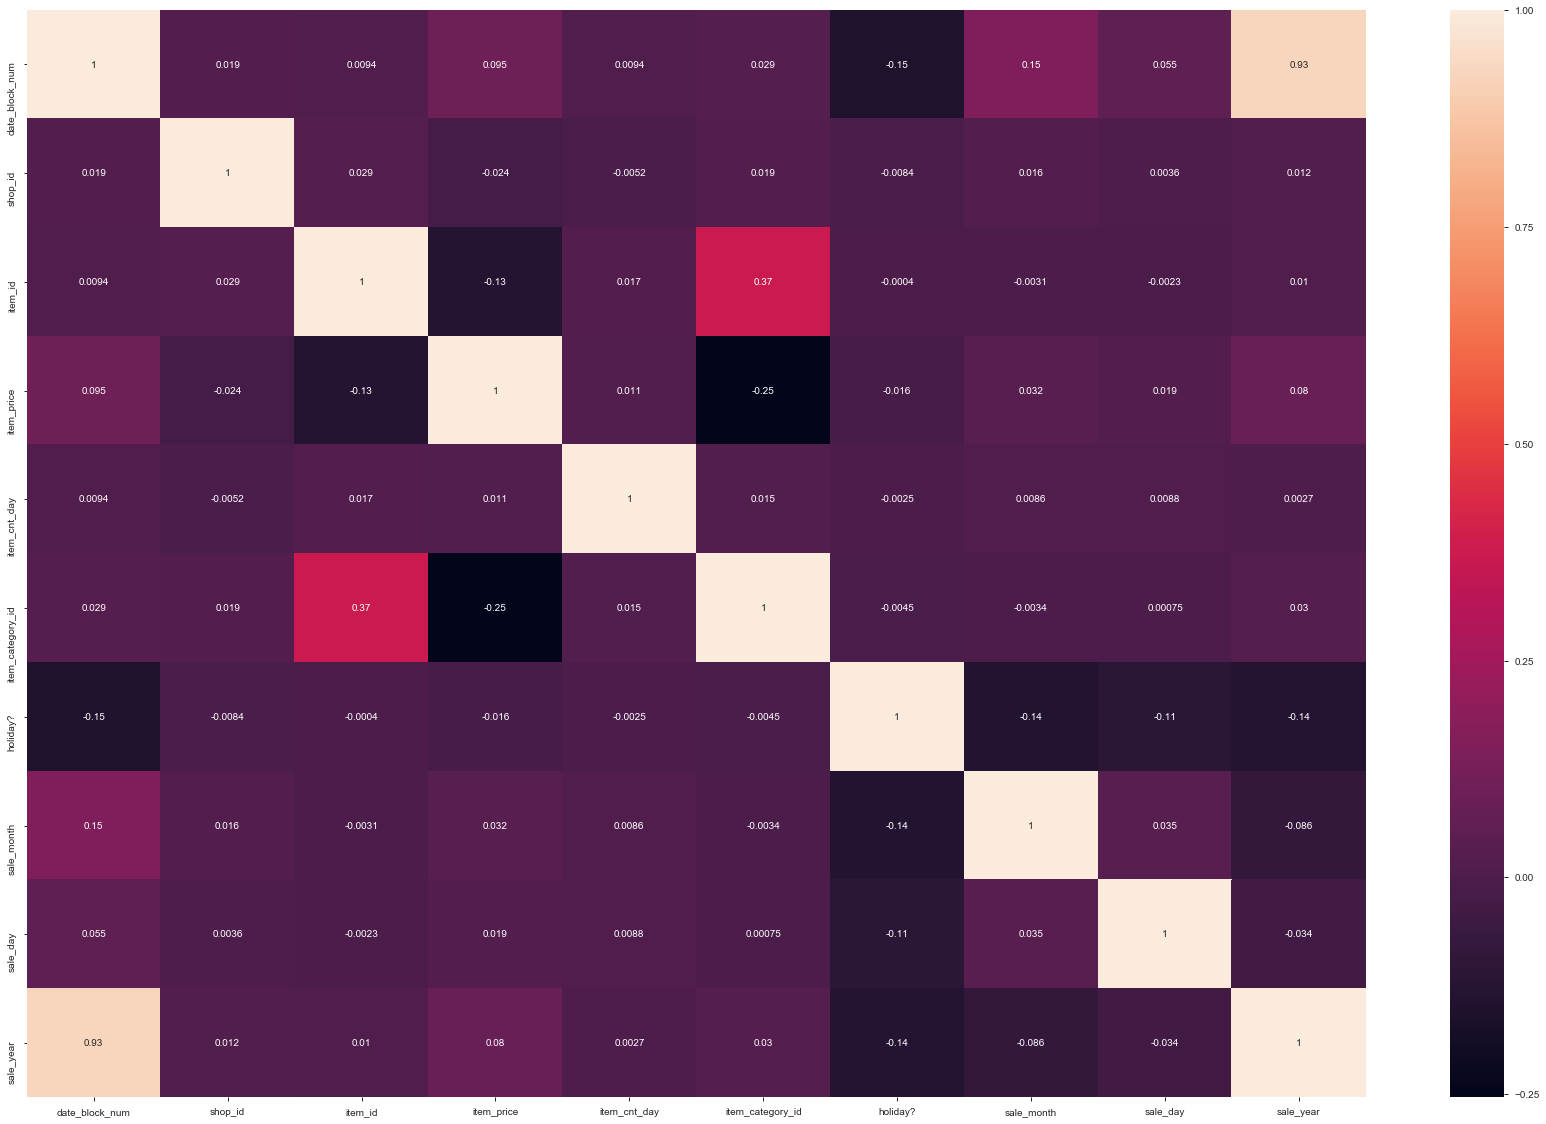

In [196]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(30, 20))
heatmap = sns.heatmap(corr, annot=True)
heatmap.tick_params(labelsize=10)

# Playing with TF-IDF and CountVectorizer

In [49]:
vect = CountVectorizer(ngram_range=(1, 3))

In [50]:
vect.fit(train['item_category_name'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [51]:
feature_names = vect.get_feature_names()

In [52]:
dtm = vect.transform(train['item_category_name'])
repr(dtm)

"<1048575x249 sparse matrix of type '<class 'numpy.int64'>'\n\twith 6183102 stored elements in Compressed Sparse Row format>"

In [53]:
print(dtm)

  (0, 85)	1
  (0, 100)	1
  (0, 133)	1
  (0, 170)	1
  (0, 171)	1
  (0, 172)	1
  (0, 189)	1
  (0, 195)	1
  (0, 196)	1
  (1, 14)	1
  (1, 107)	1
  (1, 110)	1
  (2, 3)	1
  (2, 5)	1
  (2, 6)	1
  (2, 7)	1
  (2, 33)	1
  (2, 34)	1
  (2, 107)	1
  (2, 108)	1
  (2, 109)	1
  (3, 32)	1
  (3, 85)	1
  (3, 95)	1
  (4, 17)	1
  :	:
  (1048572, 11)	1
  (1048572, 145)	1
  (1048572, 146)	1
  (1048572, 152)	1
  (1048572, 153)	1
  (1048572, 154)	1
  (1048572, 217)	1
  (1048573, 85)	1
  (1048573, 100)	1
  (1048573, 133)	1
  (1048573, 170)	1
  (1048573, 171)	1
  (1048573, 172)	1
  (1048573, 189)	1
  (1048573, 195)	1
  (1048573, 196)	1
  (1048574, 17)	1
  (1048574, 24)	1
  (1048574, 25)	1
  (1048574, 85)	1
  (1048574, 86)	1
  (1048574, 89)	1
  (1048574, 101)	1
  (1048574, 226)	1
  (1048574, 227)	1


In [54]:
pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

,1с,1с предприятие,360,3d,4k,blu,blu ray,blu ray 3d,blu ray 4k,cd,cd локального,cd локального производства,cd фирменного,cd фирменного производства,dvd,live,mp3,pc,pc гарнитуры,pc гарнитуры наушники,pc дополнительные,pc дополнительные издания,pc коллекционные,pc коллекционные издания,pc стандартные,pc стандартные издания,pc цифра,ps2,ps3,ps4,psn,psp,psvita,ray,ray 3d,ray 4k,xbox,xbox 360,аксессуары,аксессуары ps2,аксессуары ps3,аксессуары ps4,аксессуары psp,аксессуары psvita,аксессуары xbox,аксессуары xbox 360,аксессуары для,аксессуары для игр,альбомы,альбомы коврики,альбомы коврики мыши,атрибутика,аудиокниги,аудиокниги 1с,аудиокниги цифра,бизнес,бизнес литература,видео,винил,гаджеты,гаджеты роботы,гаджеты роботы спорт,гарнитуры,гарнитуры наушники,для,для дома,для дома офиса,для игр,дома,дома офиса,дома офиса цифра,дополнительные,дополнительные издания,доставка,доставка товара,игр,игровые,игровые консоли,игровые консоли ps2,игровые консоли ps3,игровые консоли ps4,игровые консоли psp,игровые консоли psvita,игровые консоли xbox,игрушки,игры,игры pc,игры pc дополнительные,игры pc коллекционные,игры pc стандартные,игры pc цифра,игры ps2,игры ps3,игры ps4,игры psp,игры psvita,игры xbox,игры xbox 360,игры аксессуары,игры аксессуары для,игры компактные,издания,карты,карты оплаты,карты оплаты live,карты оплаты psn,карты оплаты кино,кино,кино blu,кино blu ray,кино dvd,кино коллекционное,кино музыка,кино музыка игры,книги,книги аудиокниги,книги аудиокниги 1с,книги аудиокниги цифра,книги бизнес,книги бизнес литература,книги компьютерная,книги компьютерная литература,книги методические,книги методические материалы,книги путеводители,книги художественная,книги художественная литература,книги цифра,коврики,коврики мыши,коллекционное,коллекционные,коллекционные издания,компактные,компьютерная,компьютерная литература,консоли,консоли ps2,консоли ps3,консоли ps4,консоли psp,консоли psvita,консоли xbox,консоли xbox 360,литература,локального,локального производства,материалы,материалы 1с,методические,методические материалы,методические материалы 1с,музыка,музыка cd,музыка cd локального,музыка cd фирменного,музыка mp3,музыка винил,музыка игры,музыка музыкальное,музыка музыкальное видео,музыка подарочные,музыка подарочные издания,музыкальное,музыкальное видео,мыши,мягкие,мягкие игрушки,навеску,наклейки,настольные,настольные игры,настольные игры компактные,наушники,носители,носители шпиль,носители штучные,обучающие,обучающие цифра,оплаты,оплаты live,оплаты psn,оплаты кино,оплаты кино музыка,открытки,открытки наклейки,офиса,офиса цифра,питания,подарки,подарки атрибутика,подарки гаджеты,подарки гаджеты роботы,подарки мягкие,подарки мягкие игрушки,подарки настольные,подарки настольные игры,подарки открытки,подарки открытки наклейки,подарки развитие,подарки сертификаты,подарки сертификаты услуги,подарки сувениры,подарки сувениры навеску,подарки сумки,подарки сумки альбомы,подарки фигурки,подарочные,подарочные издания,предприятие,программы,программы 1с,программы 1с предприятие,программы для,программы для дома,программы обучающие,программы обучающие цифра,производства,путеводители,развитие,роботы,роботы спорт,сертификаты,сертификаты услуги,служебные,спорт,стандартные,стандартные издания,сувениры,сувениры навеску,сумки,сумки альбомы,сумки альбомы коврики,товара,услуги,фигурки,фирменного,фирменного производства,художественная,художественная литература,цифра,чистые,чистые носители,чистые носители шпиль,чистые носители штучные,шпиль,штучные,элементы,элементы питания
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,

In [55]:
train['item_category_name'].value_counts()

Кино - DVD                                  246618
Игры PC - Стандартные издания               150994
Музыка - CD локального производства         126373
Игры - PS3                                   82648
Кино - Blu-Ray                               67131
Игры - XBOX 360                              44805
Игры PC - Дополнительные издания             44687
Игры - PSP                                   20394
Программы - Для дома и офиса                 18157
Подарки - Развитие                           15568
Музыка - MP3                                 13968
Подарки - Настольные игры (компактные)       13915
Кино - Коллекционное                         13445
Кино - Blu-Ray 3D                            13062
Подарки - Мягкие игрушки                     12733
Книги - Аудиокниги                           12489
Подарки - Гаджеты, роботы, спорт             12417
Игры - PSVita                                 8650
Подарки - Сувениры (в навеску)                8240
Подарки - Настольные игры      

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(train['item_category_name'])
print(vectorizer.get_feature_names())
print(X.shape)

['1С', '360', '3D', '4K', 'Blu', 'CD', 'DVD', 'Live', 'MP3', 'PC', 'PS2', 'PS3', 'PS4', 'PSN', 'PSP', 'PSVita', 'Ray', 'XBOX', 'Аксессуары', 'Альбомы', 'Атрибутика', 'Аудиокниги', 'Бизнес', 'Винил', 'Гаджеты', 'Гарнитуры', 'Для', 'Дополнительные', 'Доставка', 'Игровые', 'Игры', 'Карты', 'Кино', 'Книги', 'Коврики', 'Коллекционное', 'Коллекционные', 'Компьютерная', 'Методические', 'Музыка', 'Музыкальное', 'Мягкие', 'Настольные', 'Наушники', 'Обучающие', 'Открытки', 'Подарки', 'Подарочные', 'Предприятие', 'Программы', 'Путеводители', 'Развитие', 'Сертификаты', 'Служебные', 'Стандартные', 'Сувениры', 'Сумки', 'Фигурки', 'Художественная', 'Цифра', 'Чистые', 'Элементы', 'видео', 'для', 'дома', 'игр', 'игрушки', 'игры', 'издания', 'компактные', 'консоли', 'литература', 'локального', 'материалы', 'мыши', 'навеску', 'наклейки', 'носители', 'оплаты', 'офиса', 'питания', 'производства', 'роботы', 'спорт', 'товара', 'услуги', 'фирменного', 'шпиль', 'штучные']
(1048575, 89)


In [57]:
X

<1048575x89 sparse matrix of type '<class 'numpy.float64'>'
	with 3109369 stored elements in Compressed Sparse Row format>

In [58]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

,1С,360,3D,4K,Blu,CD,DVD,Live,MP3,PC,PS2,PS3,PS4,PSN,PSP,PSVita,Ray,XBOX,Аксессуары,Альбомы,Атрибутика,Аудиокниги,Бизнес,Винил,Гаджеты,Гарнитуры,Для,Дополнительные,Доставка,Игровые,Игры,Карты,Кино,Книги,Коврики,Коллекционное,Коллекционные,Компьютерная,Методические,Музыка,Музыкальное,Мягкие,Настольные,Наушники,Обучающие,Открытки,Подарки,Подарочные,Предприятие,Программы,Путеводители,Развитие,Сертификаты,Служебные,Стандартные,Сувениры,Сумки,Фигурки,Художественная,Цифра,Чистые,Элементы,видео,для,дома,игр,игрушки,игры,издания,компактные,консоли,литература,локального,материалы,мыши,навеску,наклейки,носители,оплаты,офиса,питания,производства,роботы,спорт,товара,услуги,фирменного,шпиль,штучные
0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.520744,0.0,0.0,0.0,0.364293,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.520744,0.000000,0.570037,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.755348,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.655324,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.701104,0.0,0.464782,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.464782,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.276419,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.934442,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.356114,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.509825,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.395986,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.566705,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.511975,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.545785,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.545785,0.635797,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [59]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,holiday?,sale_month,sale_day
376399,0,14,16020,299.0,1,"Казань ТЦ ""ПаркХаус"" II",Настольная игра Activity Travel (для путешеств...,65,Подарки - Настольные игры (компактные),True,1,1
203030,0,13,17862,236.0,1,"Казань ТЦ ""Бехетле""",РИМСКИЕ ПРИКЛЮЧЕНИЯ,40,Кино - DVD,True,1,1
62181,0,27,8093,1249.5,1,"Москва ТЦ ""МЕГА Белая Дача II""",АВАТАР (3D BD+BD+DVD),38,Кино - Blu-Ray 3D,True,1,1
249001,0,2,11828,1699.0,1,"Адыгея ТЦ ""Мега""","Звезды PlayStation: Битва сильнейших [PS Vita,...",22,Игры - PSVita,True,1,1
174802,0,15,3325,1199.0,1,"Калуга ТРЦ ""XXI век""","FIFA 13 [PC, русская версия]",30,Игры PC - Стандартные издания,True,1,1


# Visualize the data

__Interesting notes to take away here__
- in general, it looks like sales spike on Black Friday, which is a thing in Russia too
- sales constinue to spike, but decrease, throughout October and November
- huge spike in may of 2015, I wonder why?
    - the Victory Day Parade took place in May 2015 in Russia, I wonder if this had something to do with this?

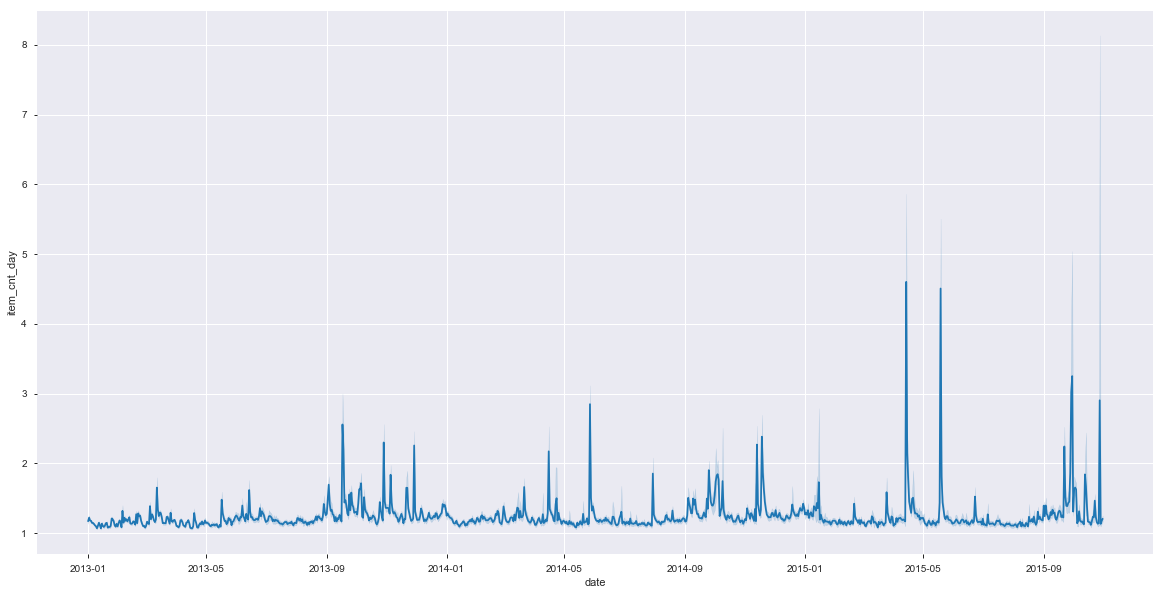

In [81]:
# create a line plot for items sold by date
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=train, x='date', y='item_cnt_day')

__This plot shows us how DVDs are the most sold item and the range of selling items in the data__

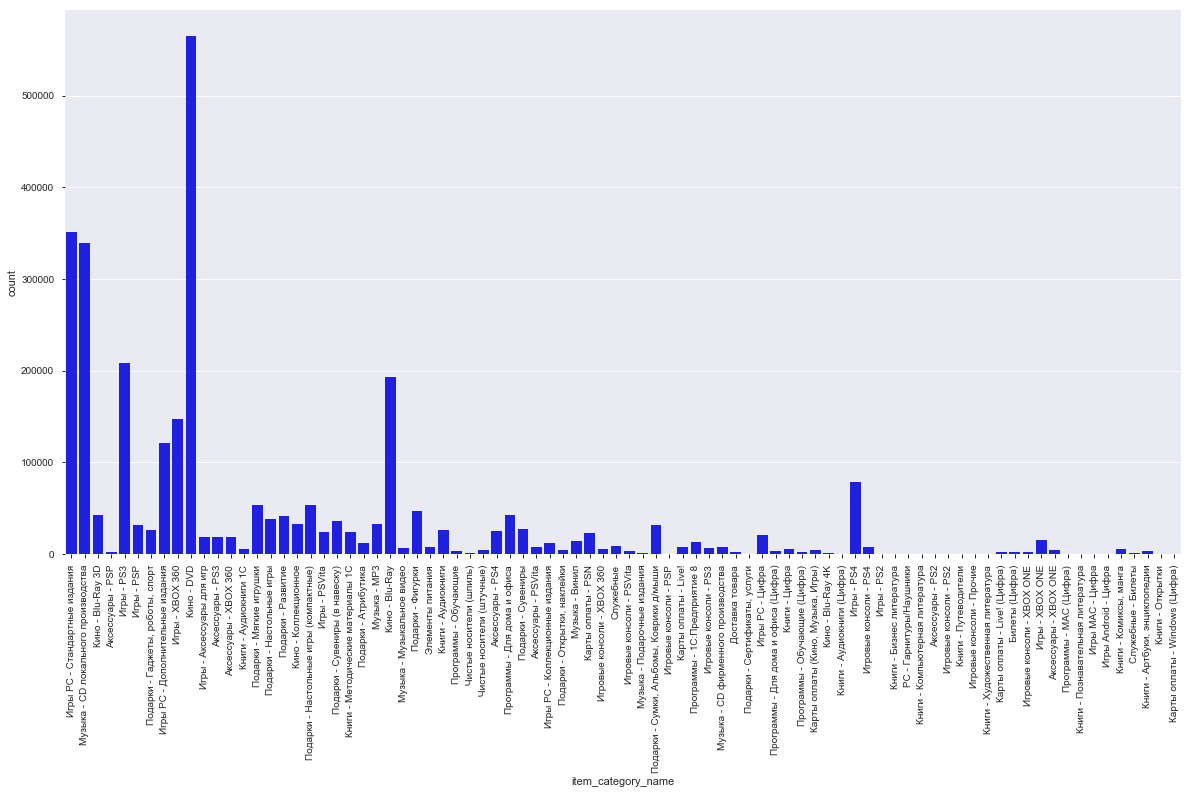

In [120]:
fig, ax = plt.subplots(figsize = (20, 10))
category_plot = sns.countplot(train['item_category_name'], color = 'blue')
# rotate the xticklabels 90 degrees
for item in category_plot.get_xticklabels():
    item.set_rotation(90)
#removes top and right borders of plot
sns.despine()

In [121]:
train.groupby('shop_name').item_cnt_day.sum().sort_values(ascending=False)

shop_name
Москва ТЦ "Семеновский"                           310777.00
Москва ТРК "Атриум"                               241920.00
Химки ТЦ "Мега"                                   185790.00
Москва ТЦ "МЕГА Теплый Стан" II                   184557.00
СПб ТК "Невский Центр"                            144934.00
Якутск Орджоникидзе, 56                           141107.00
Москва ТЦ "МЕГА Белая Дача II"                    136657.00
Воронеж (Плехановская, 13)                        100489.00
Якутск ТЦ "Центральный"                            81734.00
Сергиев Посад ТЦ "7Я"                              78990.00
Чехов ТРЦ "Карнавал"                               78079.00
Тюмень ТЦ "Гудвин"                                 76238.00
Интернет-магазин ЧС                                73478.00
Курск ТЦ "Пушкинский"                              73455.00
Калуга ТРЦ "XXI век"                               71201.00
Н.Новгород ТРЦ "Фантастика"                        69016.00
Москва МТРЦ "Афи Молл"        

__Here we can see the sales frequencies by shop__

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

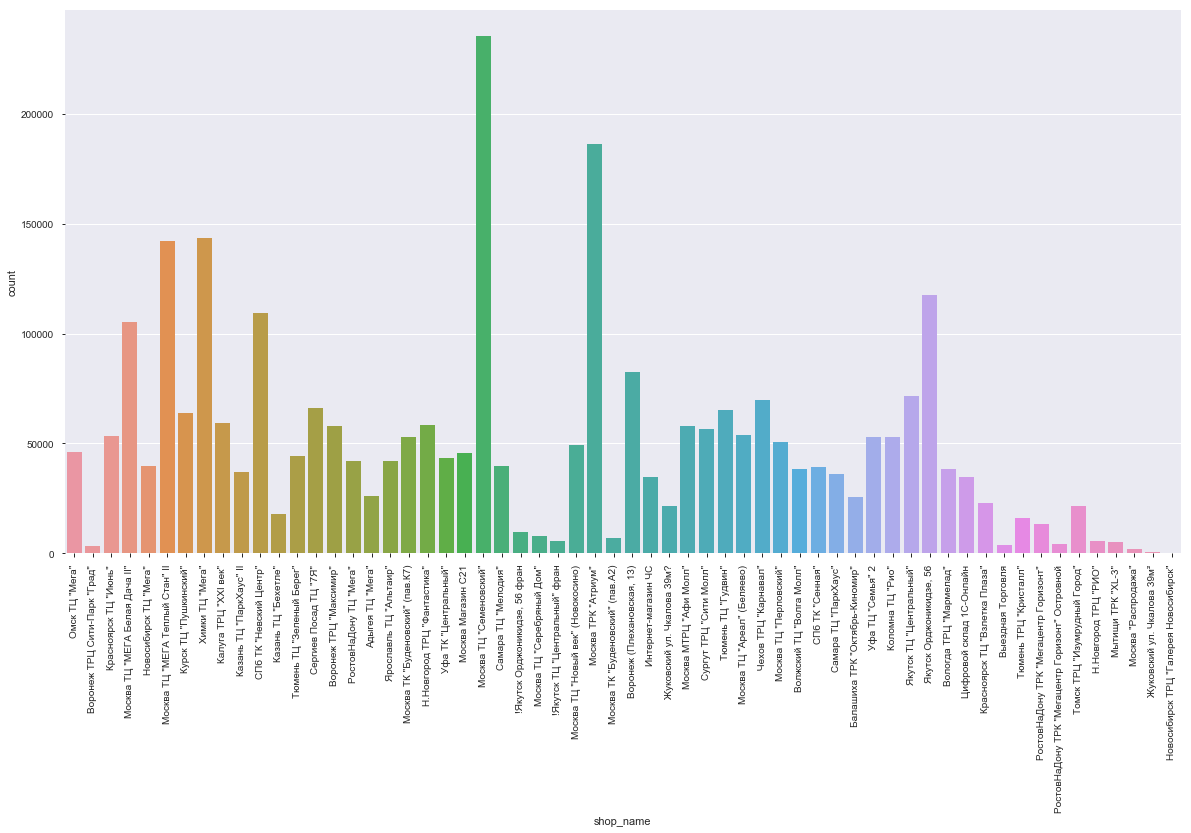

In [122]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.countplot(train['shop_name'])
plt.xticks(rotation=90)
sns.despine()

__Looks like the products that are selling the most are the lower priced items, this makes sense__
- we do have a few outliers along the y-axis, we should check some of these price, $3,000,000???

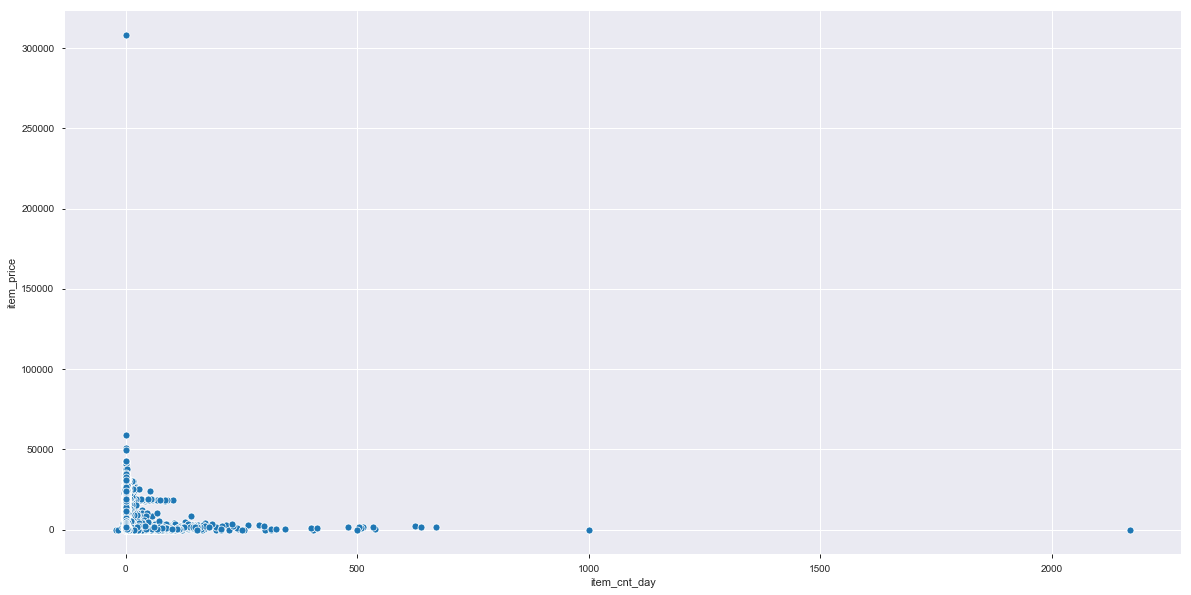

In [123]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(data = train, x = 'item_cnt_day', y = 'item_price')

__Looking at the distribution for price, seems like we could transform this feature__

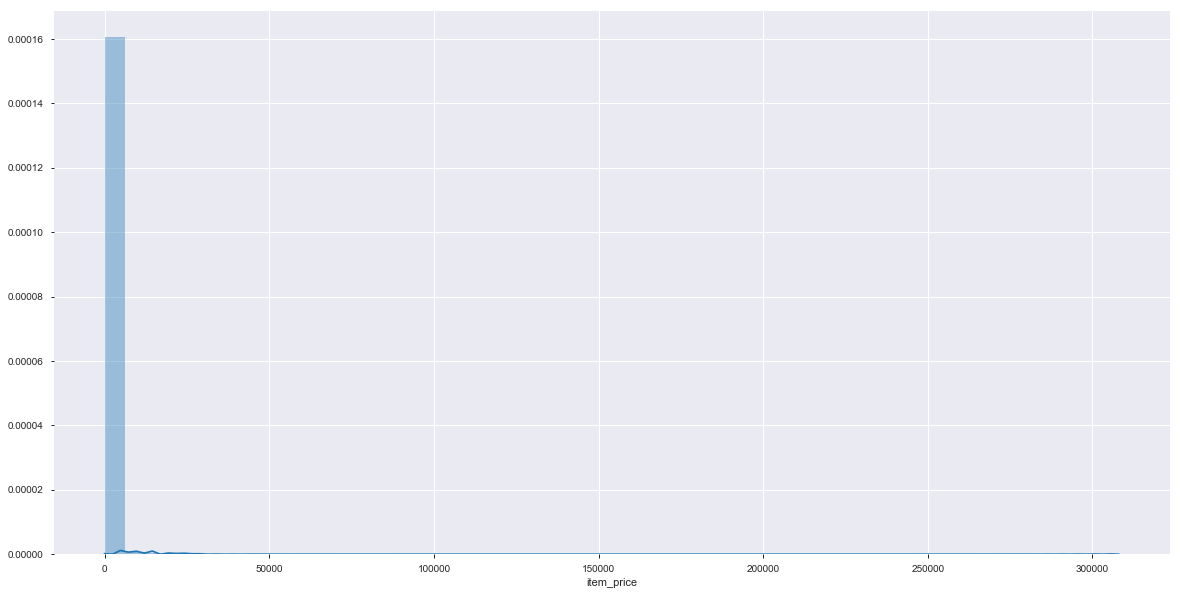

In [124]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.distplot(train['item_price'])

# Price Feature Generation

__Lets see how many products changed prices, indicating a sale occurred or a price went up or down__

In [197]:
#group item ids by their number of unique prices
price_changes = train.groupby('item_id').item_price.nunique()
price_changes = price_changes[price_changes >= 1].sort_values(ascending = False)
price_changes = pd.DataFrame(price_changes)
price_changes['item_price_changes'] = price_changes['item_price']
price_changes.drop('item_price', axis=1, inplace=True)
price_changes = price_changes.reset_index()
price_changes

,item_id,item_price_changes
0,17717,1601
1,11373,427
2,11369,344
3,11370,335
4,6675,217
5,3732,215
6,11365,207
7,3731,198
8,1855,182
9,3734,166


In [200]:
#make sure that if we merge this new feature in then we retain all of our data
train.merge(price_changes).shape
train.shape

#go ahead and merge the new feature in, sort the data by date again to be sequential datewise
train = train.merge(price_changes).sort_values(by = ['date'])
train.head()

(2935849, 16)

(2935849, 15)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,holiday?,sale_month,sale_day,sale_year,weekend?,item_price_changes
0,2013-01-01,0,38,11346,74.00,1.00,"Омск ТЦ ""Мега""","Диверсанты: Вьетнам. Специальное издание [PC, ...",30,Игры PC - Стандартные издания,True,1,1,2013,Weekday,9
3012,2013-01-01,0,51,4885,1166.00,1.00,"Тюмень ТЦ ""Зеленый Берег""","Mortal Kombat (Classics) [Xbox 360, русская до...",23,Игры - XBOX 360,True,1,1,2013,Weekday,27
365887,2013-01-01,0,19,17707,899.00,1.00,"Курск ТЦ ""Пушкинский""",Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,True,1,1,2013,Weekday,8
365886,2013-01-01,0,27,17707,898.50,1.00,"Москва ТЦ ""МЕГА Белая Дача II""",Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,True,1,1,2013,Weekday,8
365878,2013-01-01,0,28,16862,349.00,1.00,"Москва ТЦ ""МЕГА Теплый Стан"" II",ПАПАША. КИНО БЕЗ ГРАНИЦ,40,Кино - DVD,True,1,1,2013,Weekday,6


__This is very interesting, as the item price changes, the amount sold goes down, why would that be?__

In [202]:
#looking at whether the price changes correspond with more or less sales of the item
train.groupby('item_price_changes').item_cnt_day.sum().reset_index().sort_values(by = ['item_cnt_day'], ascending = False)

,item_price_changes,item_cnt_day
3,4,209741.00
4,5,196486.00
2,3,195903.00
81,91,187642.00
5,6,181791.00
6,7,158397.00
7,8,149611.00
1,2,145712.00
9,10,123109.00
8,9,121202.00


In [203]:
#use this code to check and make sure that our item price change feature indeed reflects the number of times the price
# changed depending on the item, and it does
train[train['item_id'] == 5992].groupby(train['item_price']).nunique()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,holiday?,sale_month,sale_day,sale_year,weekend?,item_price_changes
item_price,,,,,,,,,,,,,,,,
498.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
499.00,31,5,26,1,1,3,26,1,1,1,2,11,16,1,2,1
698.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
748.50,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
948.00,5,2,3,1,1,2,3,1,1,1,2,4,3,1,2,1
998.00,13,2,12,1,1,1,12,1,1,1,2,7,8,1,2,1


__Look at how our new feature correlates to our target__
- it appears as though the new feature is the highest correlated feature for our target thus far

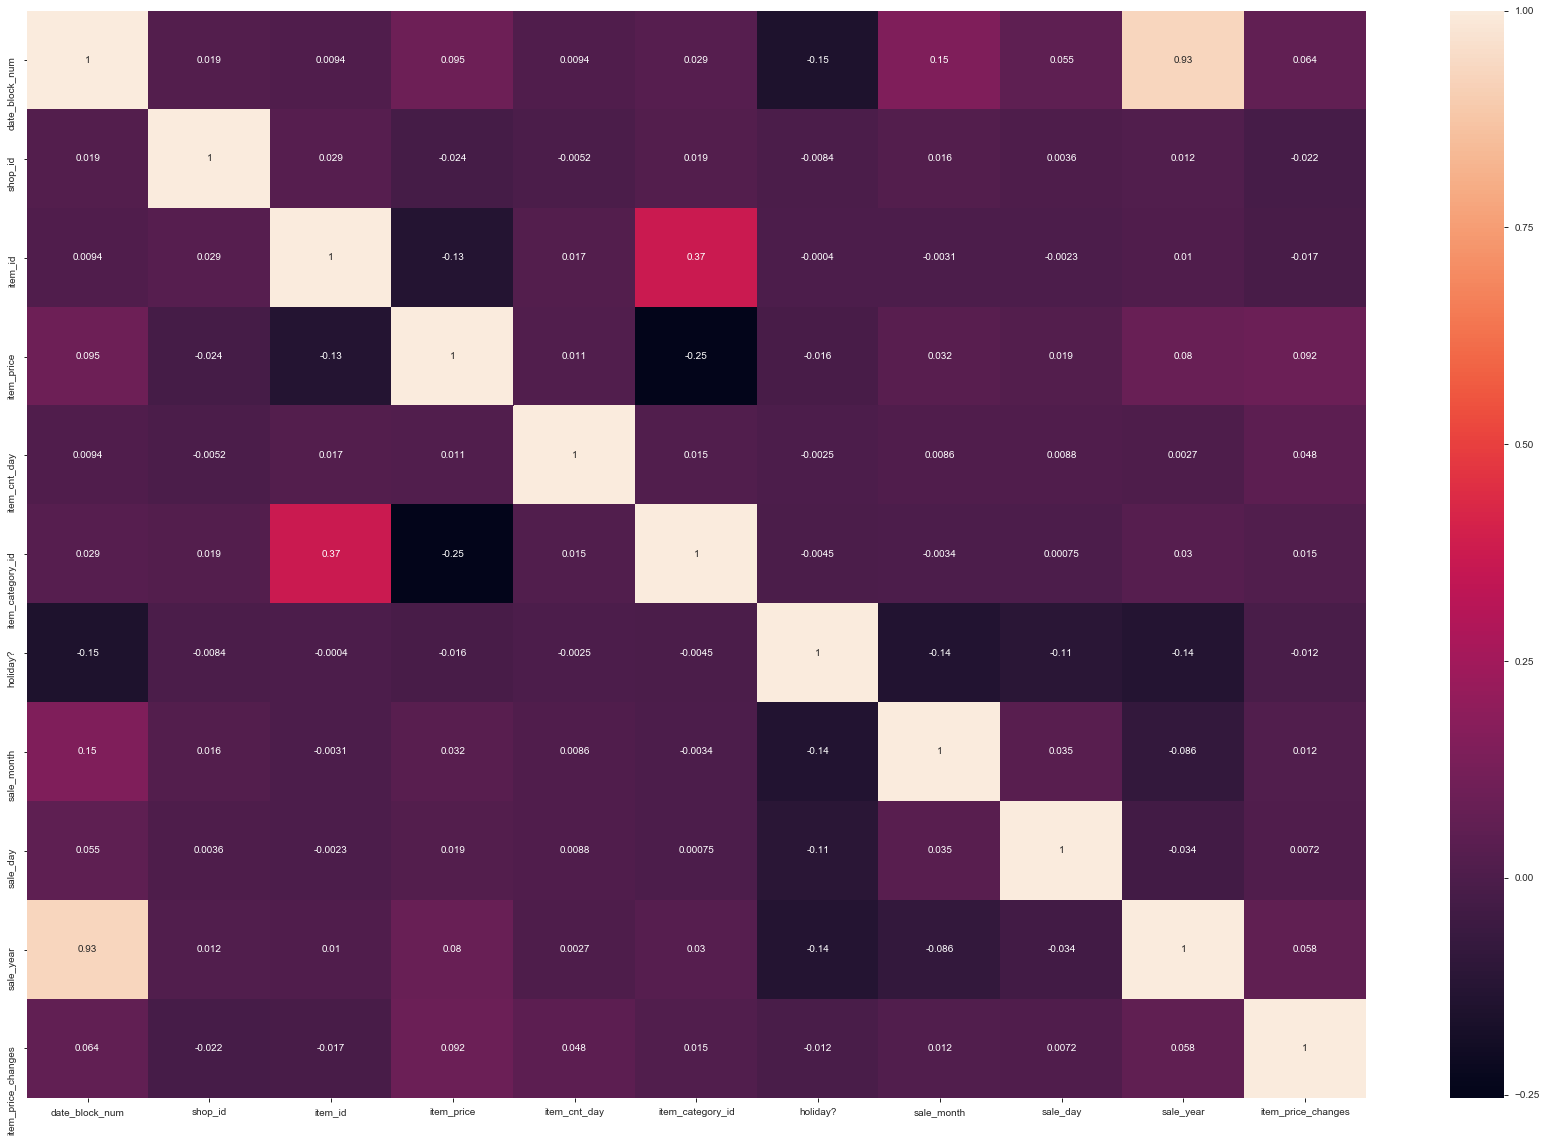

In [204]:
corr2 = train.corr()
fig, ax = plt.subplots(figsize=(30, 20))
heatmap = sns.heatmap(corr2, annot=True)
heatmap.tick_params(labelsize=10)

# Returned Items Feature Generation

In [205]:
#look at the value counts for returned items
a = train[train['item_cnt_day'] <= 0]
a['item_cnt_day'].value_counts()
a['item_cnt_day'].shape

-1.00     7252
-2.00       78
-3.00       14
-5.00        4
-4.00        3
-6.00        2
-9.00        1
-16.00       1
-22.00       1
Name: item_cnt_day, dtype: int64

(7356,)

In [206]:
#establish a list to hold the for loop info
returned = []

#append yes or no into the list based on if the item has negative values
for x in train['item_cnt_day']:
    if x < 0:
        returned.append('yes')
    else:
        returned.append('no')

#use this loop to create new column
train['item_returned?'] = returned

In [207]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,holiday?,sale_month,sale_day,sale_year,weekend?,item_price_changes,item_returned?
0,2013-01-01,0,38,11346,74.00,1.00,"Омск ТЦ ""Мега""","Диверсанты: Вьетнам. Специальное издание [PC, ...",30,Игры PC - Стандартные издания,True,1,1,2013,Weekday,9,no
3012,2013-01-01,0,51,4885,1166.00,1.00,"Тюмень ТЦ ""Зеленый Берег""","Mortal Kombat (Classics) [Xbox 360, русская до...",23,Игры - XBOX 360,True,1,1,2013,Weekday,27,no
365887,2013-01-01,0,19,17707,899.00,1.00,"Курск ТЦ ""Пушкинский""",Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,True,1,1,2013,Weekday,8,no
365886,2013-01-01,0,27,17707,898.50,1.00,"Москва ТЦ ""МЕГА Белая Дача II""",Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,True,1,1,2013,Weekday,8,no
365878,2013-01-01,0,28,16862,349.00,1.00,"Москва ТЦ ""МЕГА Теплый Стан"" II",ПАПАША. КИНО БЕЗ ГРАНИЦ,40,Кино - DVD,True,1,1,2013,Weekday,6,no


# Outlier exploration
- NOTE: we need to explore all of the odd prices, think about cutting any above a threshold

__What are the prices of some of the other items with this same id?__
- there is nothing even close to 60,000
- However, we cannot discount the fact that shipping costs can be high, but does having this one outlying cost hurt our model?

In [84]:
# train.reset_index(inplace=True)

In [86]:
train.drop(['level_0', 'index'], axis = 1, inplace = True)

In [230]:
# train[train['item_id'] == 11365]

Can we write this to a zip now?

In [229]:
# train.to_csv('EDA_train_checkpoint.csv.gz')

<Figure size 1440x720 with 0 Axes>

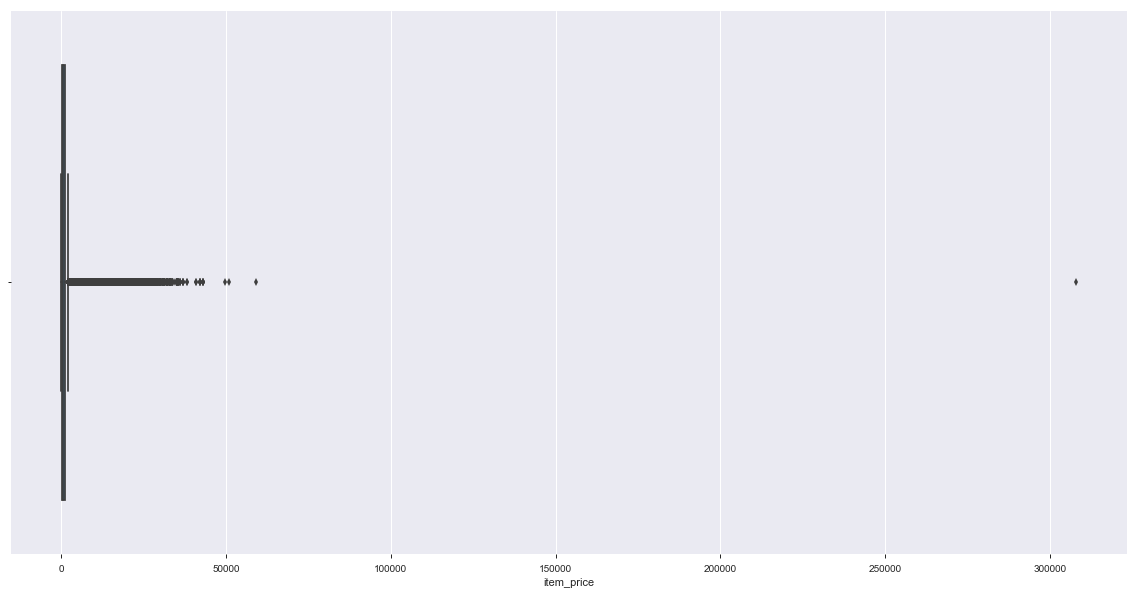

In [162]:
plt.figure(figsize = (20, 10))
sns.boxplot(train['item_price'])

This plot shows some definite outliers in the price column of our data, we need to understand what these are and look into clipping them

In [157]:
def iqr_indices_of_outliers(X):
    '''
    Detects outliers using the interquartile range (IQR) method
    
    Input: An array of a variable to detect outliers for
    Output: An array with indices of detected outliers
    '''
    q1, q3 = np.percentile(X, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    outlier_indices = np.where((X > upper_bound) | (X < lower_bound))
    return outlier_indices

def z_score_indices_of_outliers(X, threshold=3):
    '''
    Detects outliers using Z-score standardization
    
    Input: - X: A feature in your dataset
           - threshold: The number of standard deviations from the mean
                        to be considered an outlier
                        
    Output: A data frame with all outliers beyond 3 standard deviations
    '''
    X_mean = np.mean(X)
    X_stdev = np.std(X)
    z_scores = [(y - X_mean) / X_stdev for y in X]
    z_df = pd.DataFrame(z_scores)
    pos_outliers = z_df[z_df[0] > 3]
    neg_outliers = z_df[z_df[0] < -3]
    return pos_outliers; neg_outliers

In [163]:
outlier_df_price = z_score_indices_of_outliers(train['item_price'])

In [160]:
train.iloc[223, :]

date                                                2013-01-01 00:00:00
date_block_num                                                        0
shop_id                                                              41
item_id                                                           13490
item_price                                                     13990.00
item_cnt_day                                                       1.00
shop_name                                        РостовНаДону ТЦ "Мега"
item_name             Комплект «Sony PS3 Super Slim (500 Gb) (CECH-4...
item_category_id                                                     11
item_category_name                                Игровые консоли - PS3
Name: 223, dtype: object

__So, I am assuming that the prices listed here are in Rubles, thus 1 Russian Ruble is equal to .016 US Dollars, so the high thousands are not that crazy, I would like to determine if these prices are appropriate and then clip the extreme outliers, like this PS3 is 13,990 rubles, which is $222 dollars, so that is about right, that is not an outlier in my opinion__

In [165]:
outlier_df_price[outlier_df_price[0] > 10]

,0
112361,18.56
166273,14.23
283092,18.56
319836,14.23
351857,14.23
372191,14.23
419989,16.65
527903,13.88
539851,15.15
594011,15.15


# Feature Transformations

__Check negative prices__
- negative prices make no sense, we may be able to impute the mean based on the mean of other items in this category

In [210]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,holiday?,sale_month,sale_day,sale_year,weekend?,item_price_changes,item_returned?
613505,2013-05-15,4,32,2973,-1.00,1.00,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,False,5,15,2013,Weekday,36,no


In [211]:
#I want to look for the mean price of items with the same ID, this is a PS3 and there is no possible way the price
#is negative, we need to impute here, I am going to use the mean of the PS3 category
round(train['item_price'][train['item_id'] == 2973].mean(), 2)

#impute
train['item_price'].replace(-1.00, 2070.77, inplace = True)

2041.63

In [212]:
#look at the skew for all features to see if we need to improve others
train.skew()

date_block_num         0.20
shop_id               -0.07
item_id                0.26
item_price            10.75
item_cnt_day         272.83
item_category_id       0.32
holiday?               7.32
sale_month             0.05
sale_day              -0.03
sale_year              0.40
item_price_changes    15.05
dtype: float64

__Now we can look at the log of price to see if this transformation makes the distribution of the data more normal__
- it appears as though this transformation would be good for the data, I am going to go ahead and do this

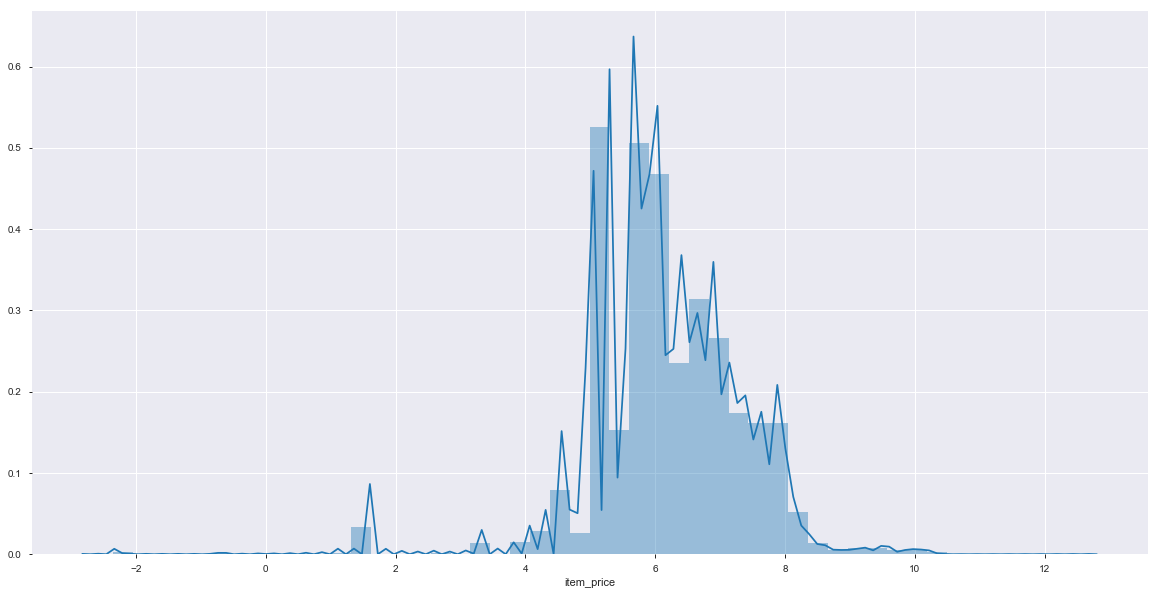

In [213]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.distplot(np.log(train['item_price']))

In [214]:
train['item_price'] = np.log(train['item_price'])

In [215]:
#checking our skew, it looks like the logarithmic transformation has lessened skew significantly
train['item_price'].skew()

-0.8103580224553192

In [237]:
# #create a list to hold our values
# a = []

# for x in train['date_block_num']:
#     if x == 0:
#         a.append(791309.40)
#     elif x == 1:
#         a.append(777464.54)
#     elif x == 2:


# train['monthly_sales'] = a

# Create Benchmark Model
- Here we can see that at least our models are working correctly and seem to be in the ballpark of the leaderboard's lower quartile with respect to RMSE

In [220]:
#gotta drop datetime first
train.drop('date', axis=1, inplace=True)

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#dummy code all categorical features
# train_dummies = pd.get_dummies(train)

# #create features and label
# label = train_dummies['item_cnt_day']
# features = train_dummies.drop('item_cnt_day', axis=1)

label = train['item_cnt_day']
features = train.drop('item_cnt_day', axis=1)

#Label Encoding
for x in train.columns[train.dtypes == 'object']:
    features[x] = features[x].factorize()[0]

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = .3, random_state = 46)

rf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1, random_state = 56)
gb = GradientBoostingRegressor(n_estimators = 1000, random_state = 45)

def get_score(model, norm=False):
        '''
        Fits the model and returns a series containing the RMSE, MAE, and R^2
        '''
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with either regular or normalized training set
        if norm == False:
            model.fit(X_train, y_train)
            totalTime = time.time() - startTime
            predictions = model.predict(X_test)
        
            r2 = model.score(X_test, y_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
        else:
            model.fit(X_train_norm, y_train)
            totalTime = time.time() - startTime
            predictions = model.predict(X_test_norm)
        
            r2 = model.score(X_test_norm, y_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        return score_results


__We need to make sure that our validation set does not contain a bunch of the same items since our test data only has 67,000 of the same items__

In [44]:
test['item_id'].isin(train['item_id']).value_counts()
X_test['item_id'].isin(X_train['item_id']).sum()
X_train.shape
X_test.shape

False    146454
True      67746
Name: item_id, dtype: int64

104664

(943717, 9)

(104858, 9)

__Its nice to start with Random Forest becuase I can see the feature importances__
- looks like the random forest did mcuh better with label encoding than dummy coding

In [52]:
# #computed with the log transformation of price
# get_score(rf)

R^2                    0.52
RMSE                   1.10
MAE                    0.25
TrainingTime(sec)   2749.46
dtype: float64

__This plot is telling us that the price of the item is the most important feature being used in the RF model, with sale day and shop id being the next most important__

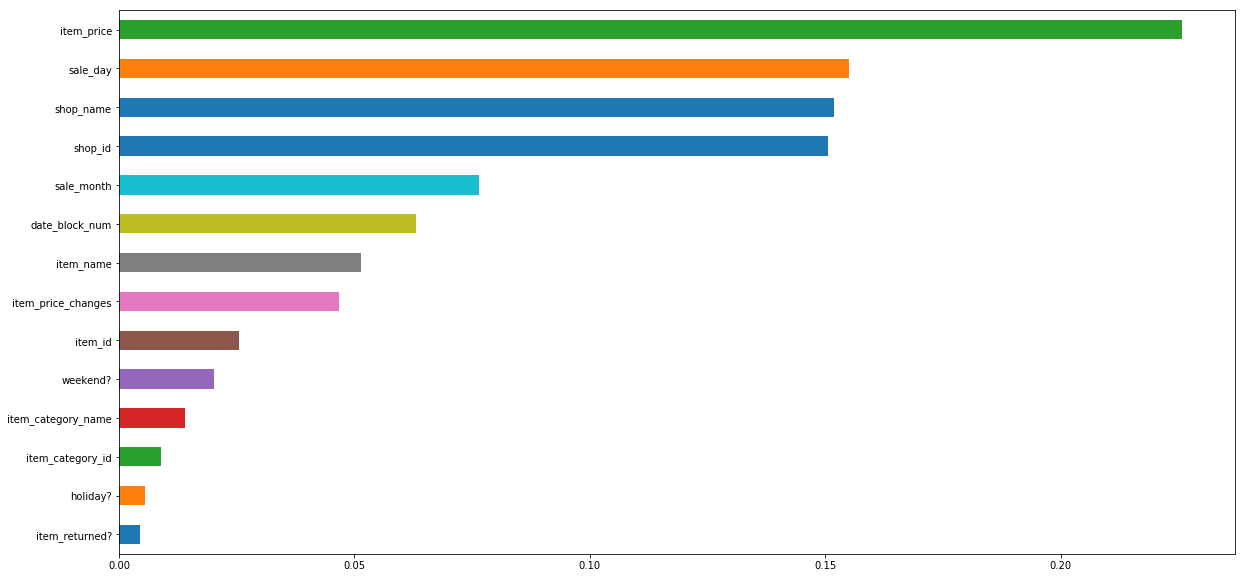

In [56]:
# #plot the feature importances
# fig, ax = plt.subplots(figsize = (20, 10))
# # plt.plot(rf.feature_importances_)
# # plt.xticks(np.arange(features.shape[1]), features.columns.tolist(), rotation = 90)
# feat_importances = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=True)
# feat_importances.plot(kind='barh')

In [14]:
get_score(gb)

R^2                    0.33
RMSE                   1.45
MAE                    0.32
TrainingTime(sec)   1333.94
dtype: float64

In [13]:
dt = DecisionTreeRegressor()
get_score(dt)

R^2                  0.30
RMSE                 1.49
MAE                  0.30
TrainingTime(sec)   12.19
dtype: float64

In [59]:
import lightgbm 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
get_score(model_lgb)

R^2                  0.24
RMSE                 1.38
MAE                  0.33
TrainingTime(sec)   10.06
dtype: float64

In [61]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
get_score(lr)

R^2                 0.07
RMSE                1.53
MAE                 0.39
TrainingTime(sec)   0.74
dtype: float64

__Checking for duplicate records__
- there appear to be none in this data

In [151]:
train.duplicated().value_counts()

False    1048575
dtype: int64